In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
import os
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-09-06 11:30:06.692775: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 11:30:06.886288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 11:30:07.838384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
file = '2013~2023 한국 기온,습도,풍속.csv'
file2 = '한국기후 평균 최고 최저.csv'

In [4]:
df = pd.read_csv(file, encoding = 'cp949')
df1 = pd.read_csv(file2, encoding = 'cp949', header = 0)
df1.head()

,\t\t지점번호,지점명,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,105,강릉,1970-01-01,3.2,10.3,-0.5
1,105,강릉,1970-01-02,1.8,5.1,-0.2
2,105,강릉,1970-01-03,-0.3,4.8,-2.2
3,105,강릉,1970-01-04,-5.9,-1.7,-12.6
4,105,강릉,1970-01-05,-7.9,-0.8,-14.7


In [5]:
df1.columns = ['지점번호', '지점명', '일시', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)']
df1 = df1.iloc[:, 2:]
df1.head()

,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,1970-01-01,3.2,10.3,-0.5
1,1970-01-02,1.8,5.1,-0.2
2,1970-01-03,-0.3,4.8,-2.2
3,1970-01-04,-5.9,-1.7,-12.6
4,1970-01-05,-7.9,-0.8,-14.7


In [6]:
df_korea = df.drop(['지점번호', '지점명'], axis = 1).groupby(['일시']).mean()
df_temp = df1.groupby(['일시']).mean()
df_korea.head(10)

,평균기온(℃),최고기온(℃),최저기온(℃),평균습도(%rh),평균풍속(m/s)
일시,,,,,
2013-01-01,-0.76250,4.43750,-6.21250,73.10000,2.33125
2013-01-02,-4.70000,0.54375,-8.98125,53.29375,3.58750
2013-01-03,-8.09375,-3.99375,-11.26250,48.90000,3.40625
2013-01-04,-6.74375,-1.15000,-11.61875,50.25000,2.03125
2013-01-05,-3.81250,1.75625,-9.41875,57.06250,2.28125
2013-01-06,-2.32500,2.52500,-5.73750,57.04375,1.96875
2013-01-07,-2.00625,3.35000,-6.72500,49.62500,1.95000
2013-01-08,-1.22500,3.76875,-5.28750,50.66250,2.15625
2013-01-09,-4.01875,-0.80625,-7.14375,45.38125,3.41250


In [7]:
filter1 = df_temp['최고기온(℃)'].isna() == True
df_temp['최고기온(℃)'][filter1] = 20.7875

In [8]:
filter2 = df_temp['최저기온(℃)'].isna() == True
df_temp['최저기온(℃)'][filter2] = 7.15625

In [9]:
df_korea = df_korea.reset_index()

In [10]:
df_korea['일시']  = pd.to_datetime(df_korea['일시'])
df_korea.set_index('일시', inplace = True)

In [11]:
#dataset = df_korea.iloc[:, :3]
dataset = df_temp.iloc[:, :]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(19585, 3)

In [12]:
train_size = int(len(data)*0.9)
test_size = len(data) - train_size
print('Train Size :', train_size, 'Test Size : ', test_size)

Train Size : 17626 Test Size :  1959


In [13]:
scaler = MinMaxScaler(feature_range = (0 , 1))
scaled_data = scaler.fit_transform(np.array(data))

In [14]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(17626, 3)

In [16]:
x_train = []
y_train = []
time_step = 720
n_col = 3

for i in range(time_step, len(scaled_data)):
    print(time_step, i)
    x_train.append(scaled_data[i-time_step:i, :n_col])
    y_train.append(scaled_data[i, :n_col])
    if i <= time_step:
        print('x_train : ', x_train)
        print('y_train : ', y_train)

720 720
x_train :  [array([[0.28644888, 0.31922063, 0.28660807],
       [0.29945554, 0.29607384, 0.3198272 ],
       [0.25937689, 0.25388222, 0.26530612],
       ...,
       [0.26285541, 0.24685028, 0.27260539],
       [0.20553539, 0.20436566, 0.23432147],
       [0.18829401, 0.18488134, 0.20974229]])]
y_train :  [array([0.17740472, 0.19865221, 0.17950246])]
720 721
720 722
720 723
720 724
720 725
720 726
720 727
720 728
720 729
720 730
720 731
720 732
720 733
720 734
720 735
720 736
720 737
720 738
720 739
720 740
720 741
720 742
720 743
720 744
720 745
720 746
720 747
720 748
720 749
720 750
720 751
720 752
720 753
720 754
720 755
720 756
720 757
720 758
720 759
720 760
720 761
720 762
720 763
720 764
720 765
720 766
720 767
720 768
720 769
720 770
720 771
720 772
720 773
720 774
720 775
720 776
720 777
720 778
720 779
720 780
720 781
720 782
720 783
720 784
720 785
720 786
720 787
720 788
720 789
720 790
720 791
720 792
720 793
720 794
720 795
720 796
720 797
720 798
720 799
720 800

720 4490
720 4491
720 4492
720 4493
720 4494
720 4495
720 4496
720 4497
720 4498
720 4499
720 4500
720 4501
720 4502
720 4503
720 4504
720 4505
720 4506
720 4507
720 4508
720 4509
720 4510
720 4511
720 4512
720 4513
720 4514
720 4515
720 4516
720 4517
720 4518
720 4519
720 4520
720 4521
720 4522
720 4523
720 4524
720 4525
720 4526
720 4527
720 4528
720 4529
720 4530
720 4531
720 4532
720 4533
720 4534
720 4535
720 4536
720 4537
720 4538
720 4539
720 4540
720 4541
720 4542
720 4543
720 4544
720 4545
720 4546
720 4547
720 4548
720 4549
720 4550
720 4551
720 4552
720 4553
720 4554
720 4555
720 4556
720 4557
720 4558
720 4559
720 4560
720 4561
720 4562
720 4563
720 4564
720 4565
720 4566
720 4567
720 4568
720 4569
720 4570
720 4571
720 4572
720 4573
720 4574
720 4575
720 4576
720 4577
720 4578
720 4579
720 4580
720 4581
720 4582
720 4583
720 4584
720 4585
720 4586
720 4587
720 4588
720 4589
720 4590
720 4591
720 4592
720 4593
720 4594
720 4595
720 4596
720 4597
720 4598
720 4599
720 4600
7

720 8478
720 8479
720 8480
720 8481
720 8482
720 8483
720 8484
720 8485
720 8486
720 8487
720 8488
720 8489
720 8490
720 8491
720 8492
720 8493
720 8494
720 8495
720 8496
720 8497
720 8498
720 8499
720 8500
720 8501
720 8502
720 8503
720 8504
720 8505
720 8506
720 8507
720 8508
720 8509
720 8510
720 8511
720 8512
720 8513
720 8514
720 8515
720 8516
720 8517
720 8518
720 8519
720 8520
720 8521
720 8522
720 8523
720 8524
720 8525
720 8526
720 8527
720 8528
720 8529
720 8530
720 8531
720 8532
720 8533
720 8534
720 8535
720 8536
720 8537
720 8538
720 8539
720 8540
720 8541
720 8542
720 8543
720 8544
720 8545
720 8546
720 8547
720 8548
720 8549
720 8550
720 8551
720 8552
720 8553
720 8554
720 8555
720 8556
720 8557
720 8558
720 8559
720 8560
720 8561
720 8562
720 8563
720 8564
720 8565
720 8566
720 8567
720 8568
720 8569
720 8570
720 8571
720 8572
720 8573
720 8574
720 8575
720 8576
720 8577
720 8578
720 8579
720 8580
720 8581
720 8582
720 8583
720 8584
720 8585
720 8586
720 8587
720 8588
7

720 12539
720 12540
720 12541
720 12542
720 12543
720 12544
720 12545
720 12546
720 12547
720 12548
720 12549
720 12550
720 12551
720 12552
720 12553
720 12554
720 12555
720 12556
720 12557
720 12558
720 12559
720 12560
720 12561
720 12562
720 12563
720 12564
720 12565
720 12566
720 12567
720 12568
720 12569
720 12570
720 12571
720 12572
720 12573
720 12574
720 12575
720 12576
720 12577
720 12578
720 12579
720 12580
720 12581
720 12582
720 12583
720 12584
720 12585
720 12586
720 12587
720 12588
720 12589
720 12590
720 12591
720 12592
720 12593
720 12594
720 12595
720 12596
720 12597
720 12598
720 12599
720 12600
720 12601
720 12602
720 12603
720 12604
720 12605
720 12606
720 12607
720 12608
720 12609
720 12610
720 12611
720 12612
720 12613
720 12614
720 12615
720 12616
720 12617
720 12618
720 12619
720 12620
720 12621
720 12622
720 12623
720 12624
720 12625
720 12626
720 12627
720 12628
720 12629
720 12630
720 12631
720 12632
720 12633
720 12634
720 12635
720 12636
720 12637
720 12638


720 16245
720 16246
720 16247
720 16248
720 16249
720 16250
720 16251
720 16252
720 16253
720 16254
720 16255
720 16256
720 16257
720 16258
720 16259
720 16260
720 16261
720 16262
720 16263
720 16264
720 16265
720 16266
720 16267
720 16268
720 16269
720 16270
720 16271
720 16272
720 16273
720 16274
720 16275
720 16276
720 16277
720 16278
720 16279
720 16280
720 16281
720 16282
720 16283
720 16284
720 16285
720 16286
720 16287
720 16288
720 16289
720 16290
720 16291
720 16292
720 16293
720 16294
720 16295
720 16296
720 16297
720 16298
720 16299
720 16300
720 16301
720 16302
720 16303
720 16304
720 16305
720 16306
720 16307
720 16308
720 16309
720 16310
720 16311
720 16312
720 16313
720 16314
720 16315
720 16316
720 16317
720 16318
720 16319
720 16320
720 16321
720 16322
720 16323
720 16324
720 16325
720 16326
720 16327
720 16328
720 16329
720 16330
720 16331
720 16332
720 16333
720 16334
720 16335
720 16336
720 16337
720 16338
720 16339
720 16340
720 16341
720 16342
720 16343
720 16344


In [17]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_col))

In [19]:
x_train.shape, y_train.shape

((18865, 720, 3), (18865, 3))

In [58]:
m_lstm = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(x_train.shape[1], n_col),
                       activation = 'relu',return_sequences = True),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(32, return_sequences = False, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    #keras.layers.LSTM(64, return_sequences = False, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dense(32, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dense(n_col)
])
m_lstm.summary()
#kernel_regularizer="l2"
#kernel_regularizer = keras.regularizers.l2(0.001)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 720, 128)          67584     
                                                                 
 lstm_19 (LSTM)              (None, 720, 64)           49408     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 3)                 51        
                                                                 
Total params: 131,043
Trainable params: 131,043
Non-tr

In [59]:
m_lstm.compile(optimizer = tf.optimizers.RMSprop(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [60]:
h = m_lstm.fit(x_train, y_train, epochs = 10, shuffle=False, batch_size = 256)

Epoch 1/10
74/74 [==============================] - 114s 2s/step - loss: 0.1453 - mae: 0.1304
Epoch 2/10
74/74 [==============================] - 112s 2s/step - loss: 0.0768 - mae: 0.0839
Epoch 3/10
74/74 [==============================] - 113s 2s/step - loss: 0.0495 - mae: 0.0794
Epoch 4/10
74/74 [==============================] - 112s 2s/step - loss: 0.0349 - mae: 0.0752
Epoch 5/10
74/74 [==============================] - 112s 2s/step - loss: 0.0269 - mae: 0.0730
Epoch 6/10
74/74 [==============================] - 113s 2s/step - loss: 0.0224 - mae: 0.0717
Epoch 7/10
74/74 [==============================] - 113s 2s/step - loss: 0.0192 - mae: 0.0688
Epoch 8/10
74/74 [==============================] - 113s 2s/step - loss: 0.0171 - mae: 0.0672
Epoch 9/10
74/74 [==============================] - 113s 2s/step - loss: 0.0155 - mae: 0.0662
Epoch 10/10
74/74 [==============================] - 113s 2s/step - loss: 0.0143 - mae: 0.0649


Text(0, 0.5, 'Losses')

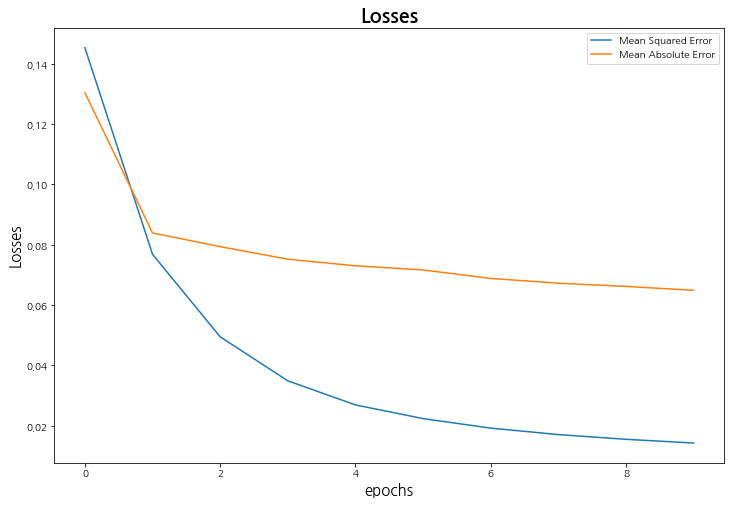

In [61]:
fig, axe = plt.subplots(figsize = (12, 8))
axe.plot(h.history['loss'])
axe.plot(h.history['mae'])
axe.legend(['Mean Squared Error', 'Mean Absolute Error'])
axe.set_title('Losses', size = 20, weight = 'bold')
axe.set_xlabel('epochs', size = 15)
axe.set_ylabel('Losses', size = 15)

In [62]:
#8/30
m_lstm.save('m6_lstm_RMSprop.h5')

In [63]:
m_lstm_RMSprop = tf.keras.models.load_model('m6_lstm_RMSprop.h5')

In [64]:
test_data = scaled_data[train_size - time_step:, :]

x_test = []
y_test = []

for i in range(time_step, len(test_data)):
    #print(time_step, i)
    x_test.append(test_data[i-time_step:i, 0:n_col])
    y_test.append(test_data[i, 0:n_col])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_col))

x_test

array([[[0.603902  , 0.65089364, 0.54819008],
        [0.63127647, 0.64986815, 0.57991956],
        [0.58076225, 0.56577791, 0.60703113],
        ...,
        [0.69676346, 0.71989452, 0.66393565],
        [0.69888082, 0.71608556, 0.67227767],
        [0.5508167 , 0.54995605, 0.57351408]],

       [[0.63127647, 0.64986815, 0.57991956],
        [0.58076225, 0.56577791, 0.60703113],
        [0.57758621, 0.59551714, 0.57783405],
        ...,
        [0.69888082, 0.71608556, 0.67227767],
        [0.5508167 , 0.54995605, 0.57351408],
        [0.48790079, 0.4225022 , 0.54774318]],

       [[0.58076225, 0.56577791, 0.60703113],
        [0.57758621, 0.59551714, 0.57783405],
        [0.5707804 , 0.59405215, 0.5590645 ],
        ...,
        [0.5508167 , 0.54995605, 0.57351408],
        [0.48790079, 0.4225022 , 0.54774318],
        [0.45946763, 0.46777029, 0.46223745]],

       ...,

       [[0.82667877, 0.76443012, 0.8717414 ],
        [0.85859044, 0.80735423, 0.88246686],
        [0.85254083, 0

In [65]:
m_lstm_RMSprop.evaluate(x_test, y_test)

62/62 [==============================] - 8s 120ms/step - loss: 0.0154 - mae: 0.0727


[0.01538977213203907, 0.07267642766237259]

In [66]:
pred = m_lstm_RMSprop.predict(x_test)
pred

62/62 [==============================] - 8s 119ms/step


array([[0.62813514, 0.62091523, 0.61348706],
       [0.64023864, 0.63219833, 0.62591314],
       [0.64556307, 0.63789564, 0.63141614],
       ...,
       [1.0075105 , 0.9813987 , 1.0153347 ],
       [0.99744654, 0.9732454 , 1.0053073 ],
       [0.98853034, 0.96572715, 0.9963677 ]], dtype=float32)

In [67]:
pred = scaler.inverse_transform(pred)
print(pred.shape)
pred

(1959, 3)


array([[15.451434 , 19.739798 , 11.177116 ],
       [15.9516115, 20.221163 , 11.698468 ],
       [16.171644 , 20.464224 , 11.929354 ],
       ...,
       [31.129124 , 35.118923 , 28.037138 ],
       [30.713228 , 34.77108  , 27.616425 ],
       [30.344767 , 34.450336 , 27.241352 ]], dtype=float32)

In [68]:
y_test = scaler.inverse_transform(y_test)
y_test

array([[ 9.65625, 11.275  ,  8.41875],
       [ 8.48125, 13.20625,  4.83125],
       [ 5.65625,  9.50625,  2.79375],
       ...,
       [26.8875 , 31.00625, 23.51875],
       [27.4    , 31.6625 , 24.34375],
       [27.2375 , 31.2125 , 24.2125 ]])

In [69]:
pred = pd.DataFrame(pred)
y_test = pd.DataFrame(y_test)

In [70]:
pred.columns = ['예측평균기온', '예측최고기온', '예측최저기온']
y_test.columns = ['실제평균기온', '실제최고기온', '실제최저기온']

In [71]:
df_pred = pd.concat((pred, y_test), axis = 1)
df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온', '예측최저기온', '실제최저기온']]
#df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온']]
df_pred

,예측평균기온,실제평균기온,예측최고기온,실제최고기온,예측최저기온,실제최저기온
0,15.451434,9.65625,19.739798,11.27500,11.177116,8.41875
1,15.951612,8.48125,20.221163,13.20625,11.698468,4.83125
2,16.171644,5.65625,20.464224,9.50625,11.929354,2.79375
3,16.063631,7.96875,20.423111,12.62500,11.820666,1.92500
4,15.698251,11.54375,20.152479,17.25625,11.445844,6.28750
...,...,...,...,...,...,...
1954,31.870564,26.24375,35.698582,29.97500,28.777565,22.85625
1955,31.538692,25.86250,35.447647,29.23125,28.448402,23.14375
1956,31.129124,26.88750,35.118923,31.00625,28.037138,23.51875
1957,30.713228,27.40000,34.771080,31.66250,27.616425,24.34375


Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


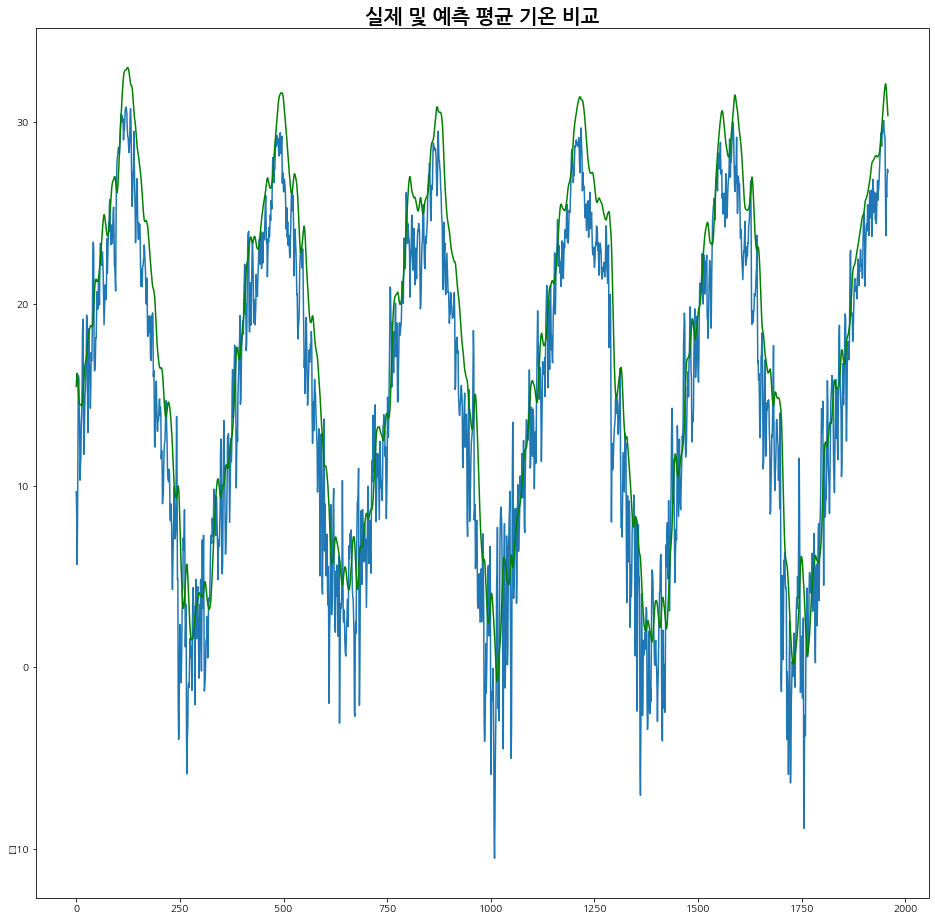

In [72]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제평균기온'])
axe.plot(df_pred['예측평균기온'], c = 'g')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

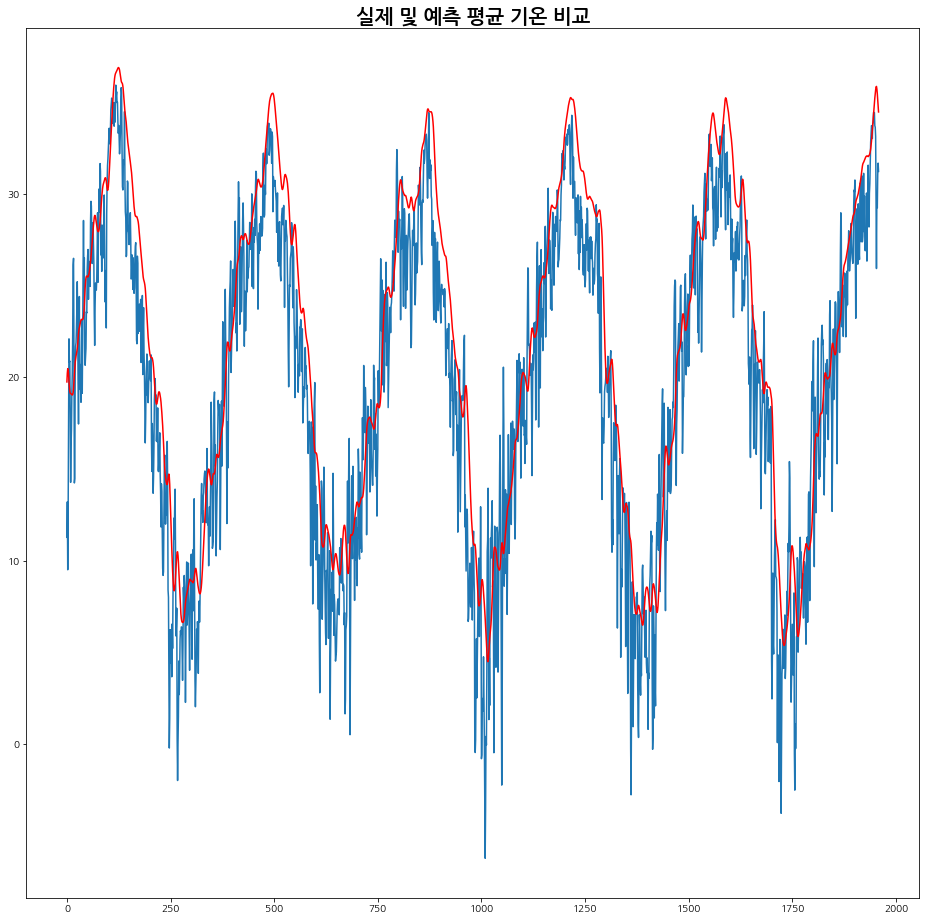

In [73]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최고기온'])
axe.plot(df_pred['예측최고기온'], c = 'r')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

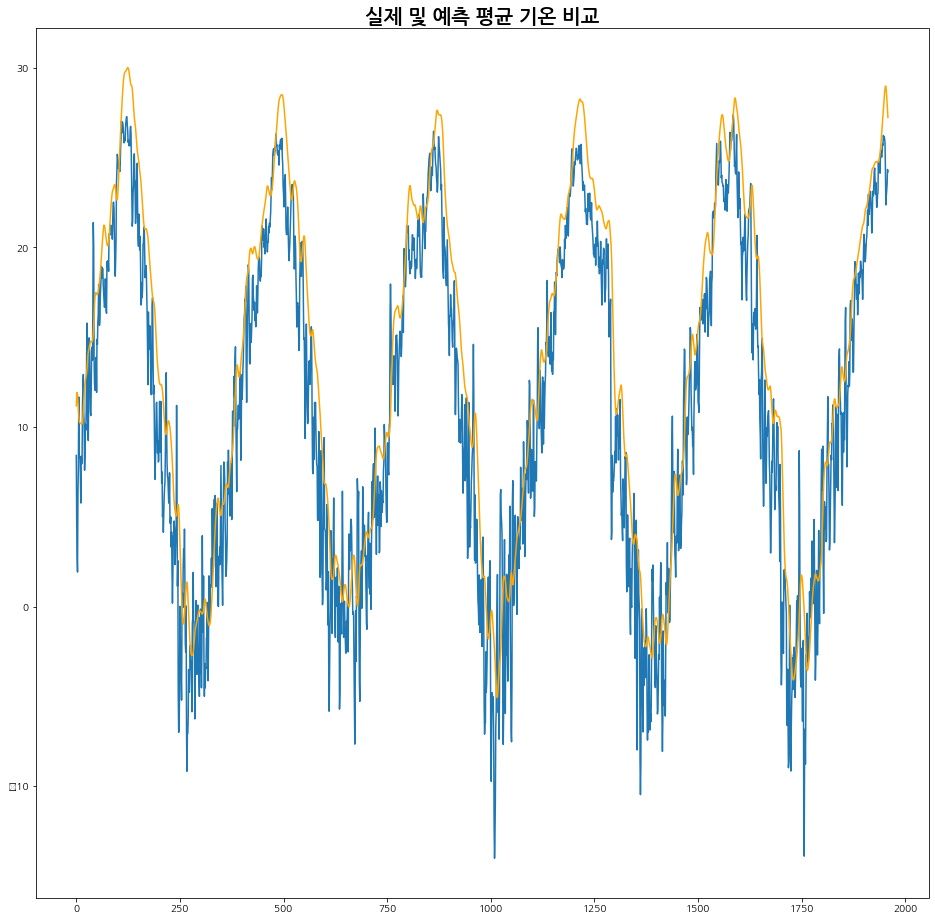

In [74]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최저기온'])
axe.plot(df_pred['예측최저기온'], c = 'orange')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

In [75]:
start_date = datetime.date(2023, 8, 16)
#print('언제의 대한민국 평균 기온을 알고 싶으신가요? (Ex. 2040-01-01, 형태로 적어주세요)')
year, month, day = map(int, input().split('-'))
target_date = datetime.date(year, month, day)

d_day = (target_date - start_date).days
print(d_day)

2025-08-15
730


In [76]:
list(x_test[-1][0])

[0.852540834845735, 0.7864049223556988, 0.8957247132429614]

In [77]:
last_array = []
for i in range(len(x_test[-1])):
    last_array.append(list(x_test[-1][i]))
len(last_array)
np.array(last_array)

array([[0.85254083, 0.78640492, 0.89572471],
       [0.88656987, 0.85789628, 0.89557575],
       [0.83802178, 0.80501025, 0.86429316],
       ...,
       [0.88006655, 0.84339291, 0.89870401],
       [0.90486993, 0.88499854, 0.90764189],
       [0.91727163, 0.9003809 , 0.92730523]])

In [78]:
for i in range(time_step, d_day):
    print(time_step, i)
    last_ar = np.array(last_array)[i-time_step:i, 0:n_col]
    print(last_ar)
    array = np.reshape(last_ar, (1, last_ar.shape[0], n_col))
    print(array.shape)
    last_array.append(list(m_lstm_RMSprop.predict(array)[0]))
    print(len(last_array))

720 720
[[0.85254083 0.78640492 0.89572471]
 [0.88656987 0.85789628 0.89557575]
 [0.83802178 0.80501025 0.86429316]
 ...
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]]
(1, 720, 3)
1/1 [==============================] - 0s 61ms/step
721
720 721
[[0.88656987 0.85789628 0.89557575]
 [0.83802178 0.80501025 0.86429316]
 [0.85949788 0.8441254  0.86027112]
 ...
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.98853034 0.96572715 0.99636769]]
(1, 720, 3)
1/1 [==============================] - 0s 56ms/step
722
720 722
[[0.83802178 0.80501025 0.86429316]
 [0.85949788 0.8441254  0.86027112]
 [0.84770115 0.81746264 0.86846417]
 ...
 [0.91727163 0.9003809  0.92730523]
 [0.98853034 0.96572715 0.99636769]
 [0.98327708 0.96092945 0.991054  ]]
(1, 720, 3)
1/1 [==============================] - 0s 61ms/step
723
720 723
[[0.85949788 0.8441254  0.86027112]
 [0.84770115 0.81746264 0.86846417]
 [0.85980036 0.82786405 0.

In [79]:
test_pred = np.array(last_array).reshape(len(last_array), n_col)

In [80]:
test_pred = scaler.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
#test_pred.columns = ['미래예측평균기온', '미래예측최고기온', '미래예측최저기온']
test_pred

,0,1,2
0,24.725000,26.800000,23.018750
1,26.131250,29.850000,23.012500
2,24.125000,27.593750,21.700000
3,25.012500,29.262500,21.531250
4,24.525000,28.125000,21.875000
...,...,...,...
725,30.579826,34.527493,27.465888
726,30.900414,34.787816,27.790495
727,31.260528,35.090727,28.157095
728,31.646254,35.424572,28.551945


/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


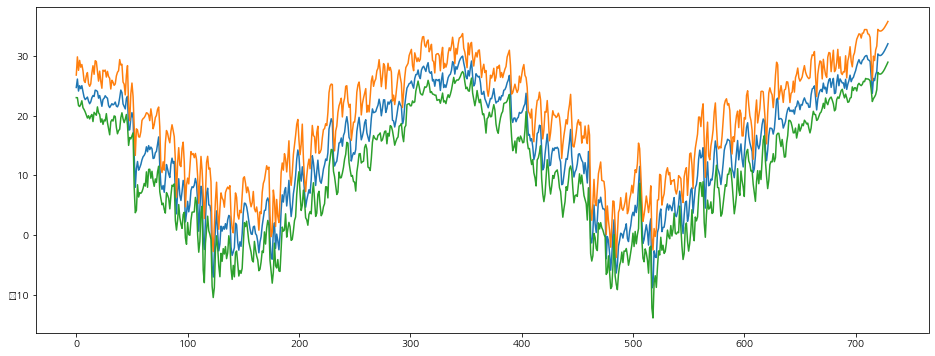

In [81]:
fig, axe = plt.subplots(figsize = (16, 6))
axe.plot(test_pred)